#**Definizione di Nuove Strategie di Federated Learning con  Flower e Pytorch**

#**Installazione dei Pacchetti Richiesti**


*   Installazione di PyTorch (Torch)
*   Installazione di Torchvision per Computer Vision
*   Installazione di Flower per l'Implementazione del Federated Learning

In [227]:
!pip install -q flwr[simulation] torch torchvision

#**All General Imports**

In [228]:
import os
import timeit
import glob
import pandas as pd
import platform
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

#**All Machine Learning Imports**

In [229]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torch import Tensor

from sklearn.metrics import f1_score

#**All Federated Learning Imports**

In [230]:
import flwr as fl

#**All Globals**

In [231]:
n_clients = 4
strategy_colors = ['red', 'green', 'blue', 'cyan']
strategy_list = ['fedavg', 'fedadagrad', 'fedadam', 'fedyogi']
strategy_type = 'fedavg'
loop_on_strategies = True     # se True
dataset = "har"                # cifar10, har
global_metrics = "F1-score-Micro"    # Accuracy, F1-score-Macro, F1-Score-Micro, F1-Score-per-Class

#**Hyper-parameters**

In [232]:
n_epochs = 5
n_rounds = 25
validation_split = 0.2
batch_size = 64
learning_rate = 0.0001
save_path = "epochs_"+str(n_epochs)+"_number_rounds_"+str(n_rounds)+"_learning_rate_"+str(learning_rate)

#**Initializations**

In [233]:
start_global_time = timeit.default_timer()

if not os.path.exists("./Outputs"):
    os.makedirs("./Outputs")

if not os.path.exists("./Outputs/"+save_path):
    os.makedirs("./Outputs/"+save_path)

DEVICE = torch.device("cpu")  # Prova "cuda" per addestramento su GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

OS = platform.system()           # Sistema Operativo

strategies_acc = []

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


#**All General Functions Definitions**

In [234]:
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d '+os.path.dirname(file_to_download))
    return True
  else:
    return None

#**Data Download**


In [235]:
if dataset == "cifar10":
  transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  )
  trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
  testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

  print("Training Set size: ", len(trainset))
  print("Test Set size: ", len(testset))
elif dataset == "har":
  out = data_download("./har_datasets_fl.zip", "1LUjU4yvBRh6FPBlIHRCD2uf5zMH6l9tC", OS)
  #urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip", filename="har-data.zip")


#**Ripartizione del Training Set per il Federated Learning**

Il **Dataset** principale viene splittato **in N parti** tante quante il numero di client. Ciascun pezzo è costituito da differenti training e validation set, mentre il test set viene condiviso tra tutti i clients, di modo tale che esso sia sempre lo stesso e possa garantire confronti affidabili. Questo test set comune infatti permette di fare dei confronti tra differenti client con un unico e stabile test set.

In [236]:
if dataset == "cifar10":
  partition_size = len(trainset) // n_clients
  lengths = [partition_size] * n_clients
  datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

  print("Size of each Dataset Partition: ", partition_size)
  print("All Dataset Partitions sizes: ", lengths)

#**Preparazione dei Dati**

Per ciascun sottoinsieme, estraiamo un training set e un validation set e li wrappiamo all'interno di DataLoader, definendo il batch size, lo shuffle, ecc. Il testset viene condiviso tra tutti i client, mentre train e validation set sono specifici per ogni client: questo è vero sia per il dataset di benchmark cifar10 che per il dataset di human activity recognition (har).

In [237]:
trainloaders = []
valloaders = []

if dataset == "cifar10":
  for ds in datasets:
      len_val = len(ds) // validation_rate
      len_train = len(ds) - len_val
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size = batch_size, shuffle=True))
      valloaders.append(DataLoader(ds_val, batch_size = batch_size))

  testloader = DataLoader(testset, batch_size = batch_size)
elif dataset == "har":
  subdirectories = [f.path for f in os.scandir('./har_datasets_fl') if f.is_dir()]

  global_X_testset = pd.DataFrame()
  global_y_testset = pd.DataFrame()

  for subdirectory in subdirectories:
    fold_number = os.path.basename(subdirectory).split('-')[0].strip()
    print("Reading : ", subdirectory)

    trainset = pd.read_csv(subdirectory+'/train/'+fold_number+'_ALL_train.csv', delimiter = ';')
    valset = trainset[-int(len(trainset)*validation_split):]
    trainset = trainset[0:-int(len(trainset)*validation_split)]
    testset = pd.read_csv(subdirectory+'/test/'+fold_number+'_ALL_test.csv', delimiter = ';')

    '''
    print(trainset.shape)
    print(valset.shape)
    print(testset.shape)
    '''

    X_train = pd.concat([trainset[str(i)] for i in range(561)], axis = 1)
    y_train = trainset['Y'] - 1

    X_val = pd.concat([valset[str(i)] for i in range(561)], axis = 1)
    y_val = valset['Y'] - 1

    X_test = pd.concat([testset[str(i)] for i in range(561)], axis = 1)
    y_test = testset['Y'] - 1

    global_X_testset = pd.concat([global_X_testset, X_test], axis=0)
    global_y_testset = pd.concat([global_y_testset, y_test], axis=0)

    training_data = torch.utils.data.TensorDataset(torch.tensor(X_train.values).float(), torch.as_tensor(y_train.values).squeeze())
    val_data = torch.utils.data.TensorDataset(torch.tensor(X_val.values).float(), torch.as_tensor(y_val.values).squeeze())
    trainloaders.append(DataLoader(training_data, batch_size=batch_size))
    valloaders.append(DataLoader(val_data, batch_size=batch_size))

test_data = torch.utils.data.TensorDataset(torch.tensor(global_X_testset.values).float(), torch.as_tensor(global_y_testset.values).squeeze())
test_dataloader = DataLoader(test_data, batch_size=batch_size)


Reading :  ./har_datasets_fl/0 - CBS
Reading :  ./har_datasets_fl/3 - STATCAN
Reading :  ./har_datasets_fl/1 - ISTAT
Reading :  ./har_datasets_fl/2 - ONS


In [238]:
print("Number of Training Subsets: ", len(trainloaders))

Number of Training Subsets:  4


In [239]:
print("Number of Validation Subsets: ", len(trainloaders))

Number of Validation Subsets:  4


#**Definizione del Modello**

In [240]:
class ConvNet(nn.Module):
    def __init__(self) -> None:
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MLP(nn.Module):
    """ Multi Layer Perceptron """
    def __init__(self) -> None:
        super(MLP, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(561, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )

    def forward(self, x: Tensor) -> Tensor:
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Crea un'istanza del modello e ne ottiene i parametri
if dataset == "cifar10":
  Net = ConvNet
elif dataset == "har":
  Net = MLP

#**Addestramento del Modello**

Nel **federated learning**, il server manda i parametri globali del modello ai suoi client, e i client aggiornano il modello locale mediante i parametri ricevuti dal server.

Dunque i client addestrano il modello sui dati locali (i quali influenza i parametri del modello localmente) e mandano i parametri del modello cambiati/aggiornati di nuovo indietro verso il server (o in alternativa, mandano i gradienti verso il server, non in questo caso i parametri completi del modello).

Abbiamo bisogno pertanto di due funzioni di supporto per aggiornare il modello locale con i parametri ricevuti dal server (set_parameters) e ottenere i parametri aggiornati dal modello locale (get_parameters). Le seguenti funzioni eseguno queste operazioni per il modello Pytorch precedentemente definito.

In sostanza usuamo **state_dict** per accedere ai tensori dei parametri del modello PyTorch. I tensori del parametro sono poi convertiti a/da una lista di array Numpy (che Flower è in grado di serializzare/deserializzare).

##**Aggiornamento dei Parametri del Modello**

In [241]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

##**Addestramento**

In [242]:
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metriche
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

#**Model Testing**

In [243]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)

    accuracy = correct / total
    f1_macro = f1_score(labels, predicted, average='macro')
    f1_micro = f1_score(labels, predicted, average='micro')
    f1_scores = f1_score(labels, predicted, average=None)

    #print("\n\n\nF1 score per class\n\n\n", f1_scores[1])

    if global_metrics == "Accuracy":
      return accuracy, loss
    elif global_metrics == "F1-score-Macro":
      return f1_macro, loss
    elif global_metrics == "F1-score-Micro":
      return f1_micro, loss
    elif global_metrics == "F1-score-per-Class":
      return f1_scores[1], loss

#**Implementazione del Client Flower**

Come sappiamo i sistemi di Federated learning sono costituiti da una parte client e una parte serve. In Flower, creiamo i client implementando delle sottoclassi di `flwr.client.Client` o `flwr.client.NumPyClient`.

Usiamo adesso `NumPyClient` dal momento che è più facile da implementare.

Per implementare il client, creiamo una sottoclasse `flwr.client.NumPyClient` e implementiamo 3 metodi `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Ritorna i parametri del modello attuale.
* `fit`: Riceve i parametri del modello dal server, addestra i parametri sui dati locali, e ritorna i parametri del modello aggiornati verso il server.
* `evaluate`: Receve i parametri del modello dal server, valuta i parametri del modello sui dati locali, e ritorna il risultato della valutazione al server.


In [244]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=n_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

Flower, di default, inizializza il modello gobale richiedendo un client casuale per l'inizializzazione dei parametri. In molti casi, vogliamo più controllo sull'inizializzazione dei parametri. Flower quindi permette quindi di passare i parametri inziali alla Strategia.

Quando chiamiamo **start_simulation**, diciamo a Flower che ci sono 4 client. Flower aòòpra va avanti e richiede la strategia  FedAvg per selezionare i client. FedAvg sa che dovrebbe selezionalre il 100% dei client disponibili (fraction_fit=1.0), così va avanti e seleziona 4 client casualmente (cioè 100% dei 4).

#**Selezione della Strategia di Aggregazione Built-In**

INFO flwr 2023-06-19 16:44:03,242 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)



Analyzing Strategy... :  Fedavg
(launch_and_evaluate pid=18954) [Client 2] evaluate, config: {}


(pid=18954) 2023-06-19 16:38:18.402059: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-19 16:44:11,079	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-19 16:44:14,751 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3913107456.0, 'memory': 7826214912.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3913107456.0, 'memory': 7826214912.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO flwr 2023-06-19 16:44:14,767 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-19 16:44:14,774 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-19 16:44:14,779 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2023-06-19

(launch_and_fit pid=21569) [Client 3] fit, config: {}
(launch_and_fit pid=21569) Epoch 1: train loss 0.024907361716032028, accuracy 0.38613188307273966
(launch_and_fit pid=21569) Epoch 2: train loss 0.019536597654223442, accuracy 0.6573759347382733


DEBUG flwr 2023-06-19 16:44:39,483 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-19 16:44:39,505 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 16:44:39,507 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:44:39,772 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-19 16:44:39,776 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 16:44:39,778 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21569) [Client 2] evaluate, config: {}
(launch_and_fit pid=21568) [Client 2] fit, config: {} [repeated 5x across cluster]
(launch_and_fit pid=21569) Epoch 4: train loss 0.007041687611490488, accuracy 0.8504418762746431 [repeated 25x across cluster]


DEBUG flwr 2023-06-19 16:44:43,439 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:44:43,458 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:44:43,701 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:44:43,707 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(launch_and_fit pid=21568) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21569) Epoch 4: train loss 0.0048727490939199924, accuracy 0.8966689326988443 [repeated 21x across cluster]


DEBUG flwr 2023-06-19 16:44:50,201 | server.py:232 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:44:50,229 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:44:50,551 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:44:50,559 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21569) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=21569) [Client 3] evaluate, config: {}
(launch_and_fit pid=21568) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21569) Epoch 2: train loss 0.004344145767390728, accuracy 0.9034670292318151 [repeated 15x across cluster]


DEBUG flwr 2023-06-19 16:44:54,240 | server.py:232 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:44:54,257 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:44:54,476 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:44:54,481 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21569) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21568) [Client 1] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=21568) Epoch 5: train loss 0.00292636058293283, accuracy 0.9415363698164514 [repeated 27x across cluster]


DEBUG flwr 2023-06-19 16:44:58,101 | server.py:232 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:44:58,123 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:44:58,366 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:44:58,377 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=21568) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21568) Epoch 3: train loss 0.002752661006525159, accuracy 0.9415363698164514 [repeated 25x across cluster]


DEBUG flwr 2023-06-19 16:45:03,021 | server.py:232 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:03,046 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:45:03,399 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:03,402 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=21568) [Client 3] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=21569) Epoch 5: train loss 0.0020352713763713837, accuracy 0.9605710401087696 [repeated 14x across cluster]


DEBUG flwr 2023-06-19 16:45:08,859 | server.py:232 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:08,877 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:45:09,101 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:09,104 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=21568) [Client 2] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=21569) Epoch 3: train loss 0.0019129067659378052, accuracy 0.9578518014955812 [repeated 26x across cluster]


DEBUG flwr 2023-06-19 16:45:12,661 | server.py:232 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:12,683 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:45:12,905 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:12,909 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-06-19 16:45:16,372 | server.py:232 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:16,390 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBU

(launch_and_evaluate pid=21568) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=21568) [Client 0] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=21569) Epoch 1: train loss 0.0017762691713869572, accuracy 0.9551325628823929 [repeated 26x across cluster]
(launch_and_evaluate pid=21569) [Client 3] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2023-06-19 16:45:22,180 | server.py:232 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:22,205 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=21568) [Client 2] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=21568) Epoch 5: train loss 0.0013968850253149867, accuracy 0.9707681849082257 [repeated 19x across cluster]


DEBUG flwr 2023-06-19 16:45:22,570 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:22,574 | server.py:218 | fit_round 11: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 11: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 3] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2023-06-19 16:45:27,027 | server.py:232 | fit_round 11 received 4 results and 0 failures
DEBUG:flwr:fit_round 11 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:27,047 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:45:27,278 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:27,283 | server.py:218 | fit_round 12: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 12: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=21569) [Client 3] fit, config: {} [repeated 5x across cluster]
(launch_and_fit pid=21568) Epoch 5: train loss 0.0012556447181850672, accuracy 0.973487423521414 [repeated 20x across cluster]


DEBUG flwr 2023-06-19 16:45:30,841 | server.py:232 | fit_round 12 received 4 results and 0 failures
DEBUG:flwr:fit_round 12 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:30,861 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:45:31,082 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:31,091 | server.py:218 | fit_round 13: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 13: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 1] evaluate, config: {} [repeated 6x across cluster]
(launch_and_fit pid=21568) [Client 0] fit, config: {} [repeated 5x across cluster]
(launch_and_fit pid=21569) Epoch 4: train loss 0.0010290357749909163, accuracy 0.9802855200543847 [repeated 27x across cluster]


DEBUG flwr 2023-06-19 16:45:34,650 | server.py:232 | fit_round 13 received 4 results and 0 failures
DEBUG:flwr:fit_round 13 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:34,671 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:45:35,010 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:35,015 | server.py:218 | fit_round 14: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 14: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=21568) [Client 2] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21568) Epoch 4: train loss 0.0010272583458572626, accuracy 0.9789259007477906 [repeated 21x across cluster]


DEBUG flwr 2023-06-19 16:45:41,347 | server.py:232 | fit_round 14 received 4 results and 0 failures
DEBUG:flwr:fit_round 14 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:41,375 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:45:41,705 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:41,707 | server.py:218 | fit_round 15: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 15: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=21568) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21569) Epoch 3: train loss 0.001016931259073317, accuracy 0.9782460910944936 [repeated 17x across cluster]


DEBUG flwr 2023-06-19 16:45:45,365 | server.py:232 | fit_round 15 received 4 results and 0 failures
DEBUG:flwr:fit_round 15 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:45,384 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:45:45,607 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:45,611 | server.py:218 | fit_round 16: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 16: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=21568) [Client 3] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=21568) Epoch 2: train loss 0.0009218304185196757, accuracy 0.9802855200543847 [repeated 28x across cluster]


DEBUG flwr 2023-06-19 16:45:49,091 | server.py:232 | fit_round 16 received 4 results and 0 failures
DEBUG:flwr:fit_round 16 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:49,109 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:45:49,325 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:49,331 | server.py:218 | fit_round 17: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 17: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 0] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2023-06-19 16:45:53,580 | server.py:232 | fit_round 17 received 4 results and 0 failures
DEBUG:flwr:fit_round 17 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:45:53,606 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=21568) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21569) Epoch 5: train loss 0.0007713134400546551, accuracy 0.9836845683208701 [repeated 26x across cluster]


DEBUG flwr 2023-06-19 16:45:53,930 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:45:53,933 | server.py:218 | fit_round 18: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 18: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=21568) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21569) Epoch 3: train loss 0.0008731131674721837, accuracy 0.9802855200543847 [repeated 16x across cluster]


DEBUG flwr 2023-06-19 16:46:00,639 | server.py:232 | fit_round 18 received 4 results and 0 failures
DEBUG:flwr:fit_round 18 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:46:00,658 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:46:01,356 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:46:01,359 | server.py:218 | fit_round 19: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 19: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=21568) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21569) Epoch 4: train loss 0.0007606192957609892, accuracy 0.9836845683208701 [repeated 22x across cluster]


DEBUG flwr 2023-06-19 16:46:05,036 | server.py:232 | fit_round 19 received 4 results and 0 failures
DEBUG:flwr:fit_round 19 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:46:05,057 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:46:05,293 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:46:05,297 | server.py:218 | fit_round 20: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 20: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21569) [Client 3] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2023-06-19 16:46:08,884 | server.py:232 | fit_round 20 received 4 results and 0 failures
DEBUG:flwr:fit_round 20 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:46:08,906 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:46:09,133 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:46:09,138 | server.py:218 | fit_round 21: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 21: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=21568) [Client 0] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=21568) Epoch 1: train loss 0.0008894452475942671, accuracy 0.9748470428280082 [repeated 24x across cluster]
(launch_and_evaluate pid=21568) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=21569) [Client 1] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=21568) Epoch 4: train loss 0.0007012716960161924, accuracy 0.9877634262406526 [repeated 16x across cluster]


DEBUG flwr 2023-06-19 16:46:15,843 | server.py:232 | fit_round 21 received 4 results and 0 failures
DEBUG:flwr:fit_round 21 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:46:15,862 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:46:16,102 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:46:16,109 | server.py:218 | fit_round 22: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 22: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2023-06-19 16:46:19,537 | server.py:232 | fit_round 22 received 4 results and 0 failures
DEBUG:flwr:fit_round 22 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:46:19,559 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:46:19,781 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:46:19,787 | server.py:218 | fit_round 23: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 23: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=21568) [Client 3] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=21569) Epoch 1: train loss 0.0007920516654849052, accuracy 0.9796057104010877 [repeated 24x across cluster]


DEBUG flwr 2023-06-19 16:46:23,380 | server.py:232 | fit_round 23 received 4 results and 0 failures
DEBUG:flwr:fit_round 23 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:46:23,398 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:46:23,627 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:46:23,631 | server.py:218 | fit_round 24: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 24: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21569) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21569) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21568) Epoch 5: train loss 0.0008571654325351119, accuracy 0.9802855200543847 [repeated 28x across cluster]


DEBUG flwr 2023-06-19 16:46:28,127 | server.py:232 | fit_round 24 received 4 results and 0 failures
DEBUG:flwr:fit_round 24 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:46:28,151 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:46:28,481 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:46:28,491 | server.py:218 | fit_round 25: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 25: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=21568) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(launch_and_fit pid=21569) [Client 2] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=21569) Epoch 3: train loss 0.0006796084926463664, accuracy 0.9857239972807614 [repeated 16x across cluster]


DEBUG flwr 2023-06-19 16:46:33,985 | server.py:232 | fit_round 25 received 4 results and 0 failures
DEBUG:flwr:fit_round 25 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:46:34,005 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:46:34,258 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
INFO flwr 2023-06-19 16:46:34,265 | server.py:147 | FL finished in 139.46012263299963
INFO:flwr:FL finished in 139.46012263299963
INFO flwr 2023-06-19 16:46:34,267 | app.py:218 | app_fit: losses_distributed [(1, 0.8794326241134752), (2, 0.9361702127659576), (3, 0.9290780141843974), (4, 0.9645390070921986), (5, 0.9645390070921986), (6, 0.9361702127659576), (7, 0.9716312056737588), (8, 0.9716312056737588), (9, 0.9716312056737588), (10, 0.9716312056737588), (11, 0.9574468085106383), (12, 0.9574

(launch_and_evaluate pid=21569) [Client 3] evaluate, config: {}


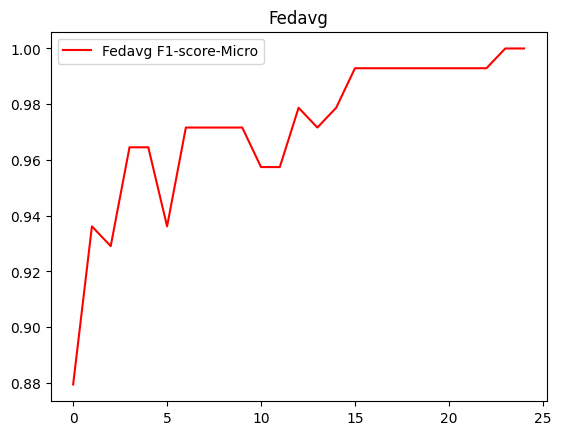

INFO flwr 2023-06-19 16:46:34,810 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)



Analyzing Strategy... :  Fedadagrad
(launch_and_fit pid=21569) [Client 3] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=21568) Epoch 5: train loss 0.0008083022548817098, accuracy 0.9830047586675731 [repeated 15x across cluster]
(launch_and_evaluate pid=21568) [Client 2] evaluate, config: {} [repeated 2x across cluster]


(pid=21568) 2023-06-19 16:44:25.357633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-19 16:46:40,834	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-19 16:46:42,430 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3915318067.0, 'memory': 7830636135.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3915318067.0, 'memory': 7830636135.0}
INFO flwr 2023-06-19 16:46:42,442 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-19 16:46:42,446 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-19 16:46:42,453 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2023-06-19

(launch_and_fit pid=23258) [Client 0] fit, config: {}
(launch_and_fit pid=23258) Epoch 1: train loss 0.0251044649630785, accuracy 0.3786539768864718


DEBUG flwr 2023-06-19 16:46:56,322 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-19 16:46:56,346 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 16:46:56,361 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:46:56,615 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-19 16:46:56,618 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 16:46:56,621 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23257) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=23257) [Client 2] evaluate, config: {}
(launch_and_fit pid=23258) [Client 0] fit, config: {} [repeated 5x across cluster]
(launch_and_fit pid=23257) Epoch 3: train loss 0.7395368218421936, accuracy 0.7403127124405167 [repeated 24x across cluster]
(launch_and_evaluate pid=23258) Epoch 4: train loss 0.4230611026287079, accuracy 0.7885791978246091


DEBUG flwr 2023-06-19 16:47:03,495 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:03,533 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=23258) [Client 1] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=23258) Epoch 5: train loss 0.38551631569862366, accuracy 0.7960571040108769 [repeated 14x across cluster]


DEBUG flwr 2023-06-19 16:47:03,911 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:47:03,917 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23257) [Client 1] evaluate, config: {}
(launch_and_fit pid=23258) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23257) Epoch 3: train loss 239.793701171875, accuracy 0.19782460910944935 [repeated 16x across cluster]
(launch_and_evaluate pid=23258) [Client 0] evaluate, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-06-19 16:47:09,264 | server.py:232 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:09,289 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:47:09,516 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:47:09,520 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-06-19 16:47:13,380 | server.py:232 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:13,408 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBU

(launch_and_fit pid=23258) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23258) Epoch 5: train loss 87.90203857421875, accuracy 0.1556764106050306 [repeated 25x across cluster]
(launch_and_evaluate pid=23257) [Client 2] evaluate, config: {} [repeated 6x across cluster]


DEBUG flwr 2023-06-19 16:47:17,976 | server.py:232 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:18,014 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:47:18,324 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:47:18,327 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=23258) [Client 3] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=23257) Epoch 1: train loss 10.449943542480469, accuracy 0.17539089055064583 [repeated 21x across cluster]
(launch_and_evaluate pid=23258) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=23257) [Client 1] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=23258) Epoch 3: train loss 7.491855621337891, accuracy 0.26580557443915703 [repeated 14x across cluster]


DEBUG flwr 2023-06-19 16:47:25,387 | server.py:232 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:25,418 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:47:25,651 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:47:25,654 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23257) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=23257) [Client 3] evaluate, config: {}
(launch_and_fit pid=23258) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23258) Epoch 4: train loss 4.415100574493408, accuracy 0.318830727396329 [repeated 23x across cluster]


DEBUG flwr 2023-06-19 16:47:29,913 | server.py:232 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:29,939 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:47:30,157 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:47:30,164 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23258) [Client 3] evaluate, config: {} [repeated 4x across cluster]


DEBUG flwr 2023-06-19 16:47:34,490 | server.py:232 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:34,524 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:47:34,869 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:47:34,874 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=23257) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23258) Epoch 5: train loss 1.3270760774612427, accuracy 0.3371855880353501 [repeated 22x across cluster]
(launch_and_evaluate pid=23257) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=23257) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23258) Epoch 1: train loss 0.6547552943229675, accuracy 0.4323589394969409 [repeated 11x across cluster]


DEBUG flwr 2023-06-19 16:47:42,140 | server.py:232 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:42,174 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:47:42,408 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:47:42,414 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23257) [Client 1] evaluate, config: {}
(launch_and_fit pid=23257) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23257) Epoch 1: train loss 0.5227840542793274, accuracy 0.4262406526172672 [repeated 20x across cluster]


DEBUG flwr 2023-06-19 16:47:46,840 | server.py:232 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:46,868 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:47:47,102 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:47:47,106 | server.py:218 | fit_round 11: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 11: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23258) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(launch_and_fit pid=23257) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23257) Epoch 2: train loss 0.4010734260082245, accuracy 0.3310673011556764 [repeated 23x across cluster]


DEBUG flwr 2023-06-19 16:47:51,605 | server.py:232 | fit_round 11 received 4 results and 0 failures
DEBUG:flwr:fit_round 11 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:51,639 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:47:51,975 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:47:51,982 | server.py:218 | fit_round 12: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 12: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23258) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=23258) [Client 3] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=23257) Epoch 4: train loss 0.27437421679496765, accuracy 0.4479945615227736 [repeated 14x across cluster]


DEBUG flwr 2023-06-19 16:47:59,147 | server.py:232 | fit_round 12 received 4 results and 0 failures
DEBUG:flwr:fit_round 12 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:47:59,172 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:47:59,398 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:47:59,405 | server.py:218 | fit_round 13: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 13: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23257) [Client 3] evaluate, config: {}
(launch_and_fit pid=23258) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23258) Epoch 3: train loss 0.16476203501224518, accuracy 0.5207341944255608 [repeated 17x across cluster]


DEBUG flwr 2023-06-19 16:48:03,853 | server.py:232 | fit_round 13 received 4 results and 0 failures
DEBUG:flwr:fit_round 13 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:03,884 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:04,141 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:04,147 | server.py:218 | fit_round 14: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 14: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23258) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(launch_and_fit pid=23258) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23257) Epoch 4: train loss 0.12412752211093903, accuracy 0.45343303874915025 [repeated 22x across cluster]


DEBUG flwr 2023-06-19 16:48:09,120 | server.py:232 | fit_round 14 received 4 results and 0 failures
DEBUG:flwr:fit_round 14 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:09,156 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:09,584 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:09,587 | server.py:218 | fit_round 15: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 15: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23257) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=23258) [Client 1] evaluate, config: {}
(launch_and_fit pid=23258) [Client 2] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23258) Epoch 2: train loss 0.3036608099937439, accuracy 0.4874235214140041 [repeated 16x across cluster]
(launch_and_evaluate pid=23257) Epoch 1: train loss 0.37934109568595886, accuracy 0.477906186267845


DEBUG flwr 2023-06-19 16:48:16,449 | server.py:232 | fit_round 15 received 4 results and 0 failures
DEBUG:flwr:fit_round 15 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:16,475 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:16,707 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:16,711 | server.py:218 | fit_round 16: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 16: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=23258) [Client 0] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=23257) Epoch 5: train loss 0.15868622064590454, accuracy 0.5316111488783141 [repeated 16x across cluster]
(launch_and_evaluate pid=23257) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=23257) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-19 16:48:21,022 | server.py:232 | fit_round 16 received 4 results and 0 failures
DEBUG:flwr:fit_round 16 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:21,057 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:21,284 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:21,290 | server.py:218 | fit_round 17: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 17: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=23257) [Client 0] fit, config: {} [repeated 5x across cluster]
(launch_and_fit pid=23258) Epoch 5: train loss 0.06546757370233536, accuracy 0.7375934738273283 [repeated 21x across cluster]
(launch_and_evaluate pid=23258) [Client 3] evaluate, config: {} [repeated 4x across cluster]


DEBUG flwr 2023-06-19 16:48:25,884 | server.py:232 | fit_round 17 received 4 results and 0 failures
DEBUG:flwr:fit_round 17 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:25,922 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:26,268 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:26,271 | server.py:218 | fit_round 18: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 18: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=23257) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23258) Epoch 5: train loss 0.06174951791763306, accuracy 0.6927260367097213 [repeated 20x across cluster]
(launch_and_evaluate pid=23258) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=23258) [Client 2] fit, config: {} [repeated 3x across cluster]
(launch_and_fit pid=23257) Epoch 2: train loss 0.0839056596159935, accuracy 0.7138001359619307 [repeated 13x across cluster]


DEBUG flwr 2023-06-19 16:48:33,305 | server.py:232 | fit_round 18 received 4 results and 0 failures
DEBUG:flwr:fit_round 18 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:33,336 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:33,545 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:33,550 | server.py:218 | fit_round 19: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 19: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23257) [Client 1] evaluate, config: {}
(launch_and_fit pid=23257) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23258) Epoch 3: train loss 0.07036188989877701, accuracy 0.6886471787899389 [repeated 22x across cluster]


DEBUG flwr 2023-06-19 16:48:37,855 | server.py:232 | fit_round 19 received 4 results and 0 failures
DEBUG:flwr:fit_round 19 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:37,882 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:38,111 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:38,118 | server.py:218 | fit_round 20: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 20: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23258) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(launch_and_fit pid=23258) [Client 2] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23257) Epoch 4: train loss 0.05387125164270401, accuracy 0.708361658735554 [repeated 22x across cluster]


DEBUG flwr 2023-06-19 16:48:42,773 | server.py:232 | fit_round 20 received 4 results and 0 failures
DEBUG:flwr:fit_round 20 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:42,807 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:43,156 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:43,160 | server.py:218 | fit_round 21: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 21: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23258) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=23258) [Client 0] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=23257) Epoch 5: train loss 0.043093182146549225, accuracy 0.6893269884432359 [repeated 12x across cluster]


DEBUG flwr 2023-06-19 16:48:50,305 | server.py:232 | fit_round 21 received 4 results and 0 failures
DEBUG:flwr:fit_round 21 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:50,336 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:50,569 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:50,576 | server.py:218 | fit_round 22: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 22: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23257) [Client 2] evaluate, config: {}
(launch_and_fit pid=23258) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23257) Epoch 4: train loss 0.03823741897940636, accuracy 0.6927260367097213 [repeated 18x across cluster]


DEBUG flwr 2023-06-19 16:48:54,896 | server.py:232 | fit_round 22 received 4 results and 0 failures
DEBUG:flwr:fit_round 22 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:54,925 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:55,144 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:55,151 | server.py:218 | fit_round 23: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 23: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23257) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(launch_and_fit pid=23258) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23258) Epoch 5: train loss 0.03342607989907265, accuracy 0.6968048946295038 [repeated 22x across cluster]


DEBUG flwr 2023-06-19 16:48:59,478 | server.py:232 | fit_round 23 received 4 results and 0 failures
DEBUG:flwr:fit_round 23 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:48:59,518 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:48:59,877 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:48:59,880 | server.py:218 | fit_round 24: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 24: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23258) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=23258) [Client 2] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23257) Epoch 3: train loss 0.029158752411603928, accuracy 0.7226376614547927 [repeated 16x across cluster]


DEBUG flwr 2023-06-19 16:49:07,508 | server.py:232 | fit_round 24 received 4 results and 0 failures
DEBUG:flwr:fit_round 24 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:49:07,533 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:49:07,767 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:49:07,771 | server.py:218 | fit_round 25: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 25: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=23257) [Client 0] evaluate, config: {}
(launch_and_fit pid=23257) [Client 1] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=23257) Epoch 5: train loss 0.015803111717104912, accuracy 0.8048946295037389 [repeated 15x across cluster]


DEBUG flwr 2023-06-19 16:49:12,120 | server.py:232 | fit_round 25 received 4 results and 0 failures
DEBUG:flwr:fit_round 25 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:49:12,148 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:49:12,372 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
INFO flwr 2023-06-19 16:49:12,380 | server.py:147 | FL finished in 149.912132424
INFO:flwr:FL finished in 149.912132424
INFO flwr 2023-06-19 16:49:12,383 | app.py:218 | app_fit: losses_distributed [(1, 0.3262411347517731), (2, 0.14893617021276595), (3, 0.19148936170212766), (4, 0.1702127659574468), (5, 0.1773049645390071), (6, 0.3120567375886525), (7, 0.3404255319148936), (8, 0.40425531914893614), (9, 0.4539007092198582), (10, 0.3191489361702128), (11, 0.5460992907801419), (12, 0.51063829787

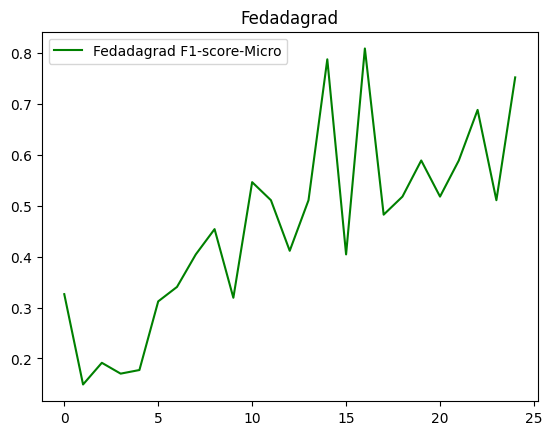

INFO flwr 2023-06-19 16:49:12,937 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)



Analyzing Strategy... :  Fedadam
(launch_and_evaluate pid=23258) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(launch_and_fit pid=23258) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=23258) Epoch 5: train loss 0.0441385954618454, accuracy 0.637661454792658 [repeated 20x across cluster]


(pid=23257) 2023-06-19 16:46:46.304557: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-19 16:49:20,329	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-19 16:49:22,044 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7830427239.0, 'object_store_memory': 3915213619.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7830427239.0, 'object_store_memory': 3915213619.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO flwr 2023-06-19 16:49:22,056 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-19 16:49:22,060 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-19 16:49:22,063 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2023-06-19

(launch_and_fit pid=24971) [Client 2] fit, config: {}
(launch_and_fit pid=24972) Epoch 1: train loss 0.025294773280620575, accuracy 0.40108769544527534


DEBUG flwr 2023-06-19 16:49:33,572 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-19 16:49:33,603 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 16:49:33,623 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:49:34,038 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-19 16:49:34,041 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 16:49:34,046 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 0] evaluate, config: {}
(launch_and_fit pid=24972) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=24972) Epoch 1: train loss 9.633628845214844, accuracy 0.3480625424881033 [repeated 20x across cluster]
(launch_and_evaluate pid=24971) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=24971) [Client 0] fit, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) Epoch 3: train loss 1.5216028690338135, accuracy 0.6471787899388172 [repeated 14x across cluster]


DEBUG flwr 2023-06-19 16:49:40,985 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:49:41,016 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:49:41,296 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:49:41,303 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24971) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=24971) Epoch 4: train loss 313.01171875, accuracy 0.36301835486063905 [repeated 23x across cluster]


DEBUG flwr 2023-06-19 16:49:45,506 | server.py:232 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:49:45,536 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:49:45,746 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:49:45,755 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24972) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2023-06-19 16:49:50,008 | server.py:232 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:49:50,052 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=24972) [Client 2] fit, config: {} [repeated 4x across cluster]


DEBUG flwr 2023-06-19 16:49:50,449 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:49:50,456 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24971) Epoch 5: train loss 284.5502014160156, accuracy 0.2848402447314752 [repeated 22x across cluster]
(launch_and_evaluate pid=24972) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24971) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=24972) Epoch 2: train loss 177.69287109375, accuracy 0.21006118286879674 [repeated 13x across cluster]


DEBUG flwr 2023-06-19 16:49:56,972 | server.py:232 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:49:56,999 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:49:57,237 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:49:57,244 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) [Client 2] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=24972) Epoch 4: train loss 41.44504928588867, accuracy 0.3195105370496261 [repeated 24x across cluster]


DEBUG flwr 2023-06-19 16:50:01,315 | server.py:232 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:01,344 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:01,580 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:01,587 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24972) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) [Client 0] fit, config: {} [repeated 4x across cluster]


DEBUG flwr 2023-06-19 16:50:05,812 | server.py:232 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:05,840 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:06,155 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:06,159 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24971) Epoch 5: train loss 50.628726959228516, accuracy 0.3602991162474507 [repeated 23x across cluster]
(launch_and_evaluate pid=24971) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=24972) Epoch 2: train loss 77.46601104736328, accuracy 0.335825968728756 [repeated 14x across cluster]


DEBUG flwr 2023-06-19 16:50:13,394 | server.py:232 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:13,423 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:13,654 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:13,657 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24971) 
(launch_and_evaluate pid=24971) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) [Client 2] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=24971) Epoch 2: train loss 181.11557006835938, accuracy 0.15363698164513936 [repeated 20x across cluster]


DEBUG flwr 2023-06-19 16:50:17,805 | server.py:232 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:17,834 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:18,088 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:18,096 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) [Client 1] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=24971) Epoch 4: train loss 84.62452697753906, accuracy 0.1787899388171312 [repeated 23x across cluster]


DEBUG flwr 2023-06-19 16:50:22,264 | server.py:232 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:22,293 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:22,535 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:22,542 | server.py:218 | fit_round 11: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 11: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24971) [Client 1] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=24971) Epoch 2: train loss 56.589412689208984, accuracy 0.4201223657375935 [repeated 16x across cluster]


DEBUG flwr 2023-06-19 16:50:29,489 | server.py:232 | fit_round 11 received 4 results and 0 failures
DEBUG:flwr:fit_round 11 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:29,521 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:29,854 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:29,858 | server.py:218 | fit_round 12: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 12: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=24971) Epoch 5: train loss 31.134750366210938, accuracy 0.42420122365737595 [repeated 16x across cluster]


DEBUG flwr 2023-06-19 16:50:34,290 | server.py:232 | fit_round 12 received 4 results and 0 failures
DEBUG:flwr:fit_round 12 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:34,318 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:34,539 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:34,546 | server.py:218 | fit_round 13: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 13: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24971) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=24972) Epoch 2: train loss 13.812638282775879, accuracy 0.4405166553365058 [repeated 24x across cluster]


DEBUG flwr 2023-06-19 16:50:38,819 | server.py:232 | fit_round 13 received 4 results and 0 failures
DEBUG:flwr:fit_round 13 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:38,846 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:39,088 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:39,096 | server.py:218 | fit_round 14: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 14: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) [Client 2] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=24972) Epoch 1: train loss 11.040879249572754, accuracy 0.5520054384772264 [repeated 18x across cluster]


DEBUG flwr 2023-06-19 16:50:45,549 | server.py:232 | fit_round 14 received 4 results and 0 failures
DEBUG:flwr:fit_round 14 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:45,579 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:45,943 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:45,949 | server.py:218 | fit_round 15: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 15: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24972) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) [Client 1] fit, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) Epoch 2: train loss 16.9160099029541, accuracy 0.4840244731475187 [repeated 12x across cluster]


DEBUG flwr 2023-06-19 16:50:50,839 | server.py:232 | fit_round 15 received 4 results and 0 failures
DEBUG:flwr:fit_round 15 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:50,866 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:51,111 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:51,118 | server.py:218 | fit_round 16: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 16: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=24972) Epoch 4: train loss 3.41703200340271, accuracy 0.760707002039429 [repeated 24x across cluster]


DEBUG flwr 2023-06-19 16:50:55,386 | server.py:232 | fit_round 16 received 4 results and 0 failures
DEBUG:flwr:fit_round 16 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:50:55,411 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:50:55,644 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:50:55,648 | server.py:218 | fit_round 17: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 17: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24972) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24971) [Client 0] fit, config: {} [repeated 5x across cluster]
(launch_and_fit pid=24971) Epoch 5: train loss 3.779350996017456, accuracy 0.6662134602311353 [repeated 23x across cluster]


DEBUG flwr 2023-06-19 16:51:01,458 | server.py:232 | fit_round 17 received 4 results and 0 failures
DEBUG:flwr:fit_round 17 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:51:01,494 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:51:01,853 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:51:01,860 | server.py:218 | fit_round 18: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 18: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24972) [Client 3] evaluate, config: {}
(launch_and_fit pid=24971) [Client 2] fit, config: {} [repeated 2x across cluster]
(launch_and_evaluate pid=24971) [Client 1] evaluate, config: {}
(launch_and_fit pid=24972) Epoch 1: train loss 11.927139282226562, accuracy 0.41536369816451396 [repeated 11x across cluster]
(launch_and_fit pid=24971) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_evaluate pid=24972) Epoch 4: train loss 8.996749877929688, accuracy 0.4799456152277362


DEBUG flwr 2023-06-19 16:51:07,450 | server.py:232 | fit_round 18 received 4 results and 0 failures
DEBUG:flwr:fit_round 18 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:51:07,476 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:51:07,699 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:51:07,704 | server.py:218 | fit_round 19: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 19: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24972) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24972) [Client 0] evaluate, config: {}
(launch_and_fit pid=24971) Epoch 1: train loss 5.474140167236328, accuracy 0.5601631543167913 [repeated 20x across cluster]


DEBUG flwr 2023-06-19 16:51:12,009 | server.py:232 | fit_round 19 received 4 results and 0 failures
DEBUG:flwr:fit_round 19 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:51:12,036 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:51:12,288 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:51:12,296 | server.py:218 | fit_round 20: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 20: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24971) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_evaluate pid=24972) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(launch_and_fit pid=24971) Epoch 3: train loss 1.8530528545379639, accuracy 0.7892590074779062 [repeated 24x across cluster]
(launch_and_fit pid=24972) [Client 0] fit, config: {} [repeated 4x across cluster]


DEBUG flwr 2023-06-19 16:51:18,090 | server.py:232 | fit_round 20 received 4 results and 0 failures
DEBUG:flwr:fit_round 20 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:51:18,127 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:51:18,495 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:51:18,505 | server.py:218 | fit_round 21: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 21: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24972) [Client 2] evaluate, config: {}
(launch_and_fit pid=24972) Epoch 5: train loss 1.417635202407837, accuracy 0.8157715839564922 [repeated 15x across cluster]
(launch_and_fit pid=24971) [Client 1] fit, config: {} [repeated 2x across cluster]
(launch_and_evaluate pid=24972) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=24972) Epoch 4: train loss 4.526133060455322, accuracy 0.7049626104690686 [repeated 17x across cluster]


DEBUG flwr 2023-06-19 16:51:24,307 | server.py:232 | fit_round 21 received 4 results and 0 failures
DEBUG:flwr:fit_round 21 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:51:24,335 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:51:24,587 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:51:24,593 | server.py:218 | fit_round 22: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 22: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24971) [Client 2] fit, config: {} [repeated 6x across cluster]


DEBUG flwr 2023-06-19 16:51:28,780 | server.py:232 | fit_round 22 received 4 results and 0 failures
DEBUG:flwr:fit_round 22 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:51:28,808 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:51:29,067 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:51:29,077 | server.py:218 | fit_round 23: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 23: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24971) Epoch 5: train loss 3.1893577575683594, accuracy 0.7443915703602991 [repeated 23x across cluster]
(launch_and_fit pid=24971) [Client 3] fit, config: {} [repeated 4x across cluster]


DEBUG flwr 2023-06-19 16:51:34,347 | server.py:232 | fit_round 23 received 4 results and 0 failures
DEBUG:flwr:fit_round 23 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:51:34,379 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 4)


(launch_and_evaluate pid=24971) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) Epoch 5: train loss 1.3995423316955566, accuracy 0.8130523453433038 [repeated 19x across cluster]


DEBUG flwr 2023-06-19 16:51:34,695 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:51:34,698 | server.py:218 | fit_round 24: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 24: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24971) [Client 2] fit, config: {} [repeated 2x across cluster]
(launch_and_evaluate pid=24971) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24972) Epoch 1: train loss 2.6465139389038086, accuracy 0.7464309993201903 [repeated 13x across cluster]


DEBUG flwr 2023-06-19 16:51:41,076 | server.py:232 | fit_round 24 received 4 results and 0 failures
DEBUG:flwr:fit_round 24 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:51:41,106 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:51:41,337 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:51:41,340 | server.py:218 | fit_round 25: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 25: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24971) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_evaluate pid=24972) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24971) Epoch 2: train loss 6.903378009796143, accuracy 0.6410605030591434 [repeated 22x across cluster]


DEBUG flwr 2023-06-19 16:51:45,618 | server.py:232 | fit_round 25 received 4 results and 0 failures
DEBUG:flwr:fit_round 25 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:51:45,648 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:51:45,874 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
INFO flwr 2023-06-19 16:51:45,876 | server.py:147 | FL finished in 143.80776348400013
INFO:flwr:FL finished in 143.80776348400013
INFO flwr 2023-06-19 16:51:45,879 | app.py:218 | app_fit: losses_distributed [(1, 0.3333333333333333), (2, 0.3262411347517731), (3, 0.24113475177304966), (4, 0.16312056737588654), (5, 0.33333333333333337), (6, 0.3049645390070922), (7, 0.3333333333333333), (8, 0.19148936170212766), (9, 0.19148936170212766), (10, 0.36879432624113473), (11, 0.3829787234042553), (12, 

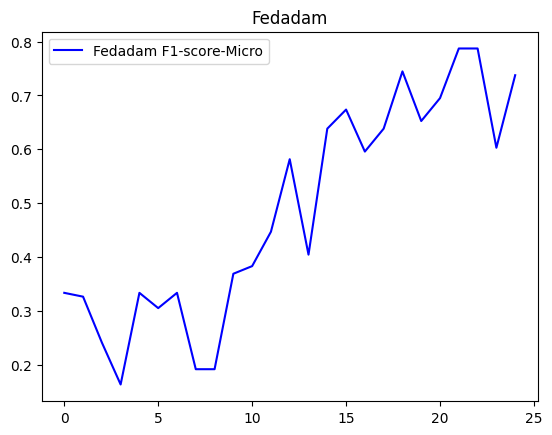

INFO flwr 2023-06-19 16:51:46,445 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)



Analyzing Strategy... :  Fedyogi
(launch_and_fit pid=24971) [Client 0] fit, config: {} [repeated 2x across cluster]
(launch_and_evaluate pid=24971) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=24971) Epoch 5: train loss 4.358818054199219, accuracy 0.6798096532970768 [repeated 6x across cluster]


(pid=24971) 2023-06-19 16:49:24.418341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-19 16:51:53,105	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-19 16:51:55,173 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3916302336.0, 'memory': 7832604672.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3916302336.0, 'memory': 7832604672.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-06-19 16:51:55,186 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-19 16:51:55,191 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-19 16:51:55,197 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2023-06-19

(launch_and_fit pid=26646) [Client 1] fit, config: {}
(launch_and_fit pid=26646) Epoch 1: train loss 0.025377169251441956, accuracy 0.3664174031271244


DEBUG flwr 2023-06-19 16:52:07,409 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-19 16:52:07,446 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 16:52:07,475 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:07,893 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-19 16:52:07,900 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 16:52:07,902 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 1] evaluate, config: {}
(launch_and_fit pid=26647) [Client 3] fit, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26647) Epoch 5: train loss 0.010735463351011276, accuracy 0.8137321549966009 [repeated 19x across cluster]
(launch_and_evaluate pid=26647) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=26646) [Client 2] fit, config: {} [repeated 4x across cluster]


DEBUG flwr 2023-06-19 16:52:13,204 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:52:13,231 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=26646) Epoch 5: train loss 0.007233829703181982, accuracy 0.8667573079537729 [repeated 19x across cluster]


DEBUG flwr 2023-06-19 16:52:13,485 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:52:13,488 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:17,077 | server.py:232 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:52:17,120 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:17,348 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:52:17,356 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26647) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(launch_and_fit pid=26647) [Client 1] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=26646) Epoch 2: train loss 0.005188432522118092, accuracy 0.8701563562202583 [repeated 24x across cluster]


DEBUG flwr 2023-06-19 16:52:20,946 | server.py:232 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:52:20,976 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:21,195 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:52:21,198 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26647) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26647) [Client 2] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=26647) Epoch 4: train loss 0.003255274845287204, accuracy 0.91162474507138 [repeated 24x across cluster]


DEBUG flwr 2023-06-19 16:52:26,951 | server.py:232 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:52:26,996 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:27,355 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:52:27,359 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26647) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26647) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=26647) Epoch 1: train loss 0.004452028311789036, accuracy 0.8959891230455472 [repeated 14x across cluster]


DEBUG flwr 2023-06-19 16:52:31,701 | server.py:232 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:52:31,726 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:31,963 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:52:31,967 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26647) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26647) [Client 3] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=26647) Epoch 3: train loss 0.002773623913526535, accuracy 0.938817131203263 [repeated 25x across cluster]


DEBUG flwr 2023-06-19 16:52:35,620 | server.py:232 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:52:35,648 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:35,878 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:52:35,882 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26647) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26647) [Client 3] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=26646) Epoch 2: train loss 0.0027588268276304007, accuracy 0.9374575118966689 [repeated 27x across cluster]


DEBUG flwr 2023-06-19 16:52:39,868 | server.py:232 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:52:39,910 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:40,279 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:52:40,283 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26647) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26647) [Client 3] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=26646) Epoch 5: train loss 0.0021317319478839636, accuracy 0.9503738953093134 [repeated 16x across cluster]


DEBUG flwr 2023-06-19 16:52:46,531 | server.py:232 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:52:46,563 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:46,802 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:52:46,806 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26647) [Client 2] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=26647) Epoch 5: train loss 0.0022740012500435114, accuracy 0.9585316111488783 [repeated 20x across cluster]


DEBUG flwr 2023-06-19 16:52:50,558 | server.py:232 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:52:50,587 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:50,845 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:52:50,852 | server.py:218 | fit_round 11: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 11: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26647) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26647) [Client 1] fit, config: {} [repeated 6x across cluster]
(launch_and_fit pid=26647) Epoch 2: train loss 0.0022795475088059902, accuracy 0.9585316111488783 [repeated 25x across cluster]


DEBUG flwr 2023-06-19 16:52:54,973 | server.py:232 | fit_round 11 received 4 results and 0 failures
DEBUG:flwr:fit_round 11 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:52:55,015 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:52:55,247 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:52:55,250 | server.py:218 | fit_round 12: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 12: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26646) [Client 1] fit, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26646) Epoch 5: train loss 0.0019696983508765697, accuracy 0.9680489462950373 [repeated 15x across cluster]


DEBUG flwr 2023-06-19 16:53:03,448 | server.py:232 | fit_round 12 received 4 results and 0 failures
DEBUG:flwr:fit_round 12 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:53:03,479 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:53:03,710 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:53:03,718 | server.py:218 | fit_round 13: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 13: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26647) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26646) [Client 3] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=26646) Epoch 5: train loss 0.0013870829716324806, accuracy 0.9666893269884432 [repeated 11x across cluster]


DEBUG flwr 2023-06-19 16:53:09,142 | server.py:232 | fit_round 13 received 4 results and 0 failures
DEBUG:flwr:fit_round 13 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:53:09,175 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=26647) [Client 0] fit, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26646) Epoch 5: train loss 0.0012260416988283396, accuracy 0.9762066621346023 [repeated 19x across cluster]


DEBUG flwr 2023-06-19 16:53:09,437 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:53:09,447 | server.py:218 | fit_round 14: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 14: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=26646) [Client 1] evaluate, config: {}
(launch_and_fit pid=26647) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=26646) Epoch 2: train loss 0.0020165136083960533, accuracy 0.9666893269884432 [repeated 14x across cluster]
(launch_and_evaluate pid=26647) Epoch 2: train loss 0.0020165136083960533, accuracy 0.9666893269884432


DEBUG flwr 2023-06-19 16:53:18,442 | server.py:232 | fit_round 14 received 4 results and 0 failures
DEBUG:flwr:fit_round 14 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:53:18,474 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:53:18,809 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:53:18,817 | server.py:218 | fit_round 15: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 15: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 0] evaluate, config: {}
(launch_and_fit pid=26647) [Client 2] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=26647) Epoch 1: train loss 0.0019914007280021906, accuracy 0.9632902787219578 [repeated 8x across cluster]
(launch_and_evaluate pid=26647) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=26646) [Client 1] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=26646) Epoch 4: train loss 0.001259051961824298, accuracy 0.9775662814411965 [repeated 17x across cluster]


DEBUG flwr 2023-06-19 16:53:25,682 | server.py:232 | fit_round 15 received 4 results and 0 failures
DEBUG:flwr:fit_round 15 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:53:25,712 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:53:25,938 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:53:25,944 | server.py:218 | fit_round 16: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 16: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26647) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26646) [Client 1] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=26646) Epoch 2: train loss 0.0016664497088640928, accuracy 0.9673691366417403 [repeated 15x across cluster]


DEBUG flwr 2023-06-19 16:53:34,614 | server.py:232 | fit_round 16 received 4 results and 0 failures
DEBUG:flwr:fit_round 16 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:53:34,648 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:53:34,975 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:53:34,983 | server.py:218 | fit_round 17: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 17: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=26646) [Client 2] evaluate, config: {}
(launch_and_fit pid=26647) [Client 0] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=26646) Epoch 1: train loss 0.0015827695606276393, accuracy 0.9755268524813052 [repeated 8x across cluster]
(launch_and_evaluate pid=26647) Epoch 1: train loss 0.00115118024405092, accuracy 0.9830047586675731
(launch_and_fit pid=26647) [Client 3] fit, config: {} [repeated 2x across cluster]
(launch_and_fit pid=26646) Epoch 4: train loss 0.001385988900437951, accuracy 0.972807613868117 [repeated 16x across cluster]


DEBUG flwr 2023-06-19 16:53:42,498 | server.py:232 | fit_round 17 received 4 results and 0 failures
DEBUG:flwr:fit_round 17 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:53:42,527 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:53:42,757 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:53:42,765 | server.py:218 | fit_round 18: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 18: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 0] evaluate, config: {}
(launch_and_fit pid=26647) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_fit pid=26646) Epoch 1: train loss 0.0010794915724545717, accuracy 0.9802855200543847 [repeated 14x across cluster]
(launch_and_evaluate pid=26646) [Client 1] evaluate, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-06-19 16:53:52,349 | server.py:232 | fit_round 18 received 4 results and 0 failures
DEBUG:flwr:fit_round 18 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:53:52,383 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=26646) Epoch 5: train loss 0.0012796607334166765, accuracy 0.9721278042148198 [repeated 8x across cluster]


DEBUG flwr 2023-06-19 16:53:52,688 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:53:52,694 | server.py:218 | fit_round 19: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 19: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26646) [Client 2] fit, config: {}
(launch_and_evaluate pid=26647) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26646) Epoch 2: train loss 0.0015083474572747946, accuracy 0.9762066621346023 [repeated 14x across cluster]
(launch_and_fit pid=26647) [Client 1] fit, config: {} [repeated 3x across cluster]


DEBUG flwr 2023-06-19 16:54:00,189 | server.py:232 | fit_round 19 received 4 results and 0 failures
DEBUG:flwr:fit_round 19 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:54:00,218 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:54:00,458 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:54:00,460 | server.py:218 | fit_round 20: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 20: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=26646) [Client 3] evaluate, config: {}
(launch_and_fit pid=26646) Epoch 4: train loss 0.0018410063348710537, accuracy 0.973487423521414 [repeated 14x across cluster]
(launch_and_fit pid=26647) [Client 0] fit, config: {} [repeated 2x across cluster]
(launch_and_evaluate pid=26647) Epoch 1: train loss 0.0011041739489883184, accuracy 0.9796057104010877
(launch_and_fit pid=26646) Epoch 3: train loss 0.0014901191461831331, accuracy 0.9741672331747111 [repeated 8x across cluster]
(launch_and_fit pid=26647) [Client 2] fit, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-06-19 16:54:10,941 | server.py:232 | fit_round 20 received 4 results and 0 failures
DEBUG:flwr:fit_round 20 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:54:10,983 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:54:11,231 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:54:11,240 | server.py:218 | fit_round 21: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 21: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 1] evaluate, config: {}
(launch_and_fit pid=26646) Epoch 4: train loss 0.0033107991330325603, accuracy 0.9571719918422842 [repeated 12x across cluster]
(launch_and_fit pid=26646) [Client 0] fit, config: {} [repeated 2x across cluster]
(launch_and_evaluate pid=26647) [Client 3] evaluate, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-06-19 16:54:18,638 | server.py:232 | fit_round 21 received 4 results and 0 failures
DEBUG:flwr:fit_round 21 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:54:18,667 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:54:18,900 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:54:18,908 | server.py:218 | fit_round 22: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 22: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26646) Epoch 1: train loss 0.0012399620609357953, accuracy 0.9775662814411965 [repeated 14x across cluster]
(launch_and_fit pid=26647) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_evaluate pid=26647) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26646) Epoch 5: train loss 0.0013550029834732413, accuracy 0.9721278042148198 [repeated 8x across cluster]
(launch_and_fit pid=26646) [Client 3] fit, config: {}


DEBUG flwr 2023-06-19 16:54:29,325 | server.py:232 | fit_round 22 received 4 results and 0 failures
DEBUG:flwr:fit_round 22 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:54:29,354 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:54:29,588 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:54:29,596 | server.py:218 | fit_round 23: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 23: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 1] evaluate, config: {}
(launch_and_fit pid=26646) Epoch 1: train loss 0.0011876029893755913, accuracy 0.9755268524813052 [repeated 12x across cluster]
(launch_and_fit pid=26647) [Client 0] fit, config: {} [repeated 3x across cluster]
(launch_and_evaluate pid=26647) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=26646) Epoch 4: train loss 0.00112771091517061, accuracy 0.9796057104010877 [repeated 16x across cluster]
(launch_and_fit pid=26647) [Client 3] fit, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-06-19 16:54:37,372 | server.py:232 | fit_round 23 received 4 results and 0 failures
DEBUG:flwr:fit_round 23 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:54:37,404 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:54:37,721 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:54:37,724 | server.py:218 | fit_round 24: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 24: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26647) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_fit pid=26646) Epoch 3: train loss 0.002426134655252099, accuracy 0.9639700883752549 [repeated 8x across cluster]
(launch_and_fit pid=26646) [Client 0] fit, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-06-19 16:54:47,762 | server.py:232 | fit_round 24 received 4 results and 0 failures
DEBUG:flwr:fit_round 24 received 4 results and 0 failures


(launch_and_fit pid=26646) Epoch 5: train loss 0.0012989232782274485, accuracy 0.9768864717878993 [repeated 14x across cluster]
(launch_and_fit pid=26647) [Client 3] fit, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-06-19 16:54:47,797 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:54:48,033 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-19 16:54:48,041 | server.py:218 | fit_round 25: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 25: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26646) [Client 2] evaluate, config: {}
(launch_and_fit pid=26646) Epoch 1: train loss 0.0014246564824134111, accuracy 0.9782460910944936 [repeated 13x across cluster]
(launch_and_fit pid=26646) [Client 0] fit, config: {} [repeated 4x across cluster]
(launch_and_evaluate pid=26647) [Client 1] evaluate, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-06-19 16:54:57,716 | server.py:232 | fit_round 25 received 4 results and 0 failures
DEBUG:flwr:fit_round 25 received 4 results and 0 failures
DEBUG flwr 2023-06-19 16:54:57,774 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-19 16:54:58,104 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
INFO flwr 2023-06-19 16:54:58,112 | server.py:147 | FL finished in 182.8998134970002
INFO:flwr:FL finished in 182.8998134970002
INFO flwr 2023-06-19 16:54:58,114 | app.py:218 | app_fit: losses_distributed [(1, 0.8581560283687942), (2, 0.9716312056737588), (3, 0.9716312056737588), (4, 0.9645390070921986), (5, 0.9716312056737588), (6, 0.9503546099290779), (7, 0.9574468085106383), (8, 0.9645390070921986), (9, 0.9858156028368794), (10, 0.9858156028368794), (11, 0.9645390070921986), (12, 0.971631

(launch_and_fit pid=26646) Epoch 5: train loss 0.0020410558208823204, accuracy 0.9694085656016316 [repeated 8x across cluster]


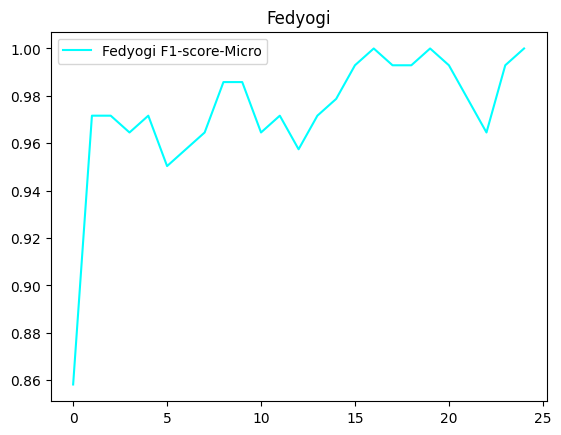

In [245]:
loop_list = strategy_list

if loop_on_strategies is False:
  loop_list = [strategy_type]

for strategy_type in loop_list:
  print("\nAnalyzing Strategy... : ", strategy_type.capitalize())

  # Crea un'istanza del modello e ne ottiene i parametri
  if dataset == "cifar10":
    params = get_parameters(ConvNet())
  elif dataset == "har":
    params = get_parameters(MLP())

  if strategy_type == strategy_list[0]:
    # Creazione della Strategia FedAvg
    # Passa i parametri alla strategia per l'inizializzazione dei parametri lato Server
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.3,
        min_fit_clients=n_clients,
        min_evaluate_clients=3,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == strategy_list[1]:
    # Creazione della Strategia FedAdagrad
    strategy = fl.server.strategy.FedAdagrad(
        fraction_fit=1.0,
        fraction_evaluate=0.3,
        min_fit_clients=n_clients,
        min_evaluate_clients=3,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == strategy_list[2]:
    # Creazione della Strategia FedAdam
    strategy = fl.server.strategy.FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=0.3,
        min_fit_clients=n_clients,
        min_evaluate_clients=3,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == strategy_list[3]:
    # Creazione della Strategia FedYogi
    # Passa i parametri alla strategia per l'inizializzazione dei parametri lato Server
    strategy = fl.server.strategy.FedYogi(
        fraction_fit=1.0,
        fraction_evaluate=0.3,
        min_fit_clients=n_clients,
        min_evaluate_clients=3,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  # Specifica le risorse del client se si ha bisogno della GPU (default a 1 per CPU e 0 per GPU)
  client_resources = None
  if DEVICE.type == "cuda":
      client_resources = {"num_gpus": 1}

  # Avvio della Simulazione
  history = fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=n_clients,
      config=fl.server.ServerConfig(num_rounds=n_rounds),
      strategy=strategy,
      client_resources=client_resources,
  )

  '''
  federated_weights = server.get_weights()
  # Salvare i pesi del modello su disco
  torch.save(federated_weights, "federated_model_weights.pt")
  '''

  acc = [m[1] for m in history.losses_distributed]
  plt.figure()												# generate a new window
  plt.plot(acc, label=strategy_type.capitalize()+' '+global_metrics, color = strategy_colors[loop_list.index(strategy_type)])
  plt.legend()
  plt.title(strategy_type.capitalize())
  plt.savefig("./Outputs/"+save_path+"/"+strategy_type+".png", dpi = 300)
  plt.show()
  plt.close()

  strategies_acc.append((strategy_type, max(acc), acc[-1]))

#**Salvataggio dei Dati**

In [246]:
strategies_acc_df = pd.DataFrame(strategies_acc, columns = ["Strategy", "Best Round "+global_metrics, "Last Round "+global_metrics])
strategies_acc_df.to_csv("./Outputs/"+save_path+"/"+"fl_accuracies_over_strategies.csv")
strategies_acc_df.to_excel("./Outputs/"+save_path+"/"+"fl_accuracies_over_strategies.xlsx")
strategies_acc_df

,Strategy,Best Round F1-score-Micro,Last Round F1-score-Micro
0,fedavg,1.000000,1.000000
1,fedadagrad,0.808511,0.751773
2,fedadam,0.787234,0.737589
3,fedyogi,1.000000,1.000000


#**Salvataggio delle Figure**

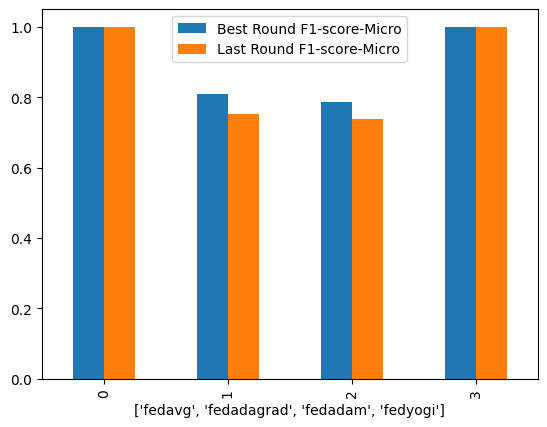

In [247]:
#strategies_acc_df = pd.DataFrame(strategies_acc, columns=['Strategy', 'Max Accuracy', 'Last Accuracy'])
strategies_acc_df.plot.bar()
plt.xlabel(loop_list)
plt.savefig("./Outputs/"+save_path+"/"+"fl_accuracies_over_strategies.png", dpi = 300)
plt.show()

#**Salvataggio dei Risultati**

In [248]:
print("\n Plots and CSVs saved in ./Outputs/'+save_path+' folder.")
print("Zipping...")
os.system('zip -r '+save_path+'_with_'+global_metrics.lower()+'.zip '+'./Outputs/'+save_path)

print("\n\n Elapsed Time: ", timeit.default_timer() - start_global_time)


 Plots and CSVs saved in ./Outputs/'+save_path+' folder.
Zipping...


 Elapsed Time:  658.7349186870001
